# [Tensorflow Tutorial - Object Detection](https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_object_detection.ipynb)

In [51]:
import os
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
import io
import scipy.misc
import numpy as np

from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

# Load utilities

In [52]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    
      Puts image into numpy array to feed into tensorflow graph.
      Note that by convention we put it into a numpy array with shape
      (height, width, channels), where channels=3 for RGB.

      Args:
        path: the file path to the image

      Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    # if path looks like 'http:abcdefg....'
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    # if path doesn't http url...
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))
        (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape((1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : 'models/research/object_detection/test_images/image2.jpg',
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [
 (0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)
]

# Install required packages including Visualization Tools

In [53]:
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [54]:
%%bash
apt install -y protobuf-compiler
cd ./models/research
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Processing /kaggle/working/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1644063 sha256=002d6a98072770eb2a1d3aa17b6a9a17f3331c9620346c2b1d173f86a89077d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-g1wl9s_8/wheels/d3/e0/37/addaa349be05bc9a8e02e02876c3154afc70272d2a09a30920
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [55]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as ops_utils

PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index.values())

dict_values([{'id': 1, 'name': 'person'}, {'id': 2, 'name': 'bicycle'}, {'id': 3, 'name': 'car'}, {'id': 4, 'name': 'motorcycle'}, {'id': 5, 'name': 'airplane'}, {'id': 6, 'name': 'bus'}, {'id': 7, 'name': 'train'}, {'id': 8, 'name': 'truck'}, {'id': 9, 'name': 'boat'}, {'id': 10, 'name': 'traffic light'}, {'id': 11, 'name': 'fire hydrant'}, {'id': 13, 'name': 'stop sign'}, {'id': 14, 'name': 'parking meter'}, {'id': 15, 'name': 'bench'}, {'id': 16, 'name': 'bird'}, {'id': 17, 'name': 'cat'}, {'id': 18, 'name': 'dog'}, {'id': 19, 'name': 'horse'}, {'id': 20, 'name': 'sheep'}, {'id': 21, 'name': 'cow'}, {'id': 22, 'name': 'elephant'}, {'id': 23, 'name': 'bear'}, {'id': 24, 'name': 'zebra'}, {'id': 25, 'name': 'giraffe'}, {'id': 27, 'name': 'backpack'}, {'id': 28, 'name': 'umbrella'}, {'id': 31, 'name': 'handbag'}, {'id': 32, 'name': 'tie'}, {'id': 33, 'name': 'suitcase'}, {'id': 34, 'name': 'frisbee'}, {'id': 35, 'name': 'skis'}, {'id': 36, 'name': 'snowboard'}, {'id': 37, 'name': 'spor

# Build a detection model and load pre-trained model weights

In [56]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'CenterNet HourGlass104 Keypoints 512x512'
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

# Load model from Tensorflow Hub
hub_model = hub.load(model_handle)
if hub_model != None:
    print('Model loaded with success')

Selected model:CenterNet HourGlass104 Keypoints 512x512
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1
Model loaded with success


# Loading an image

models/research/object_detection/test_images/image1.jpg


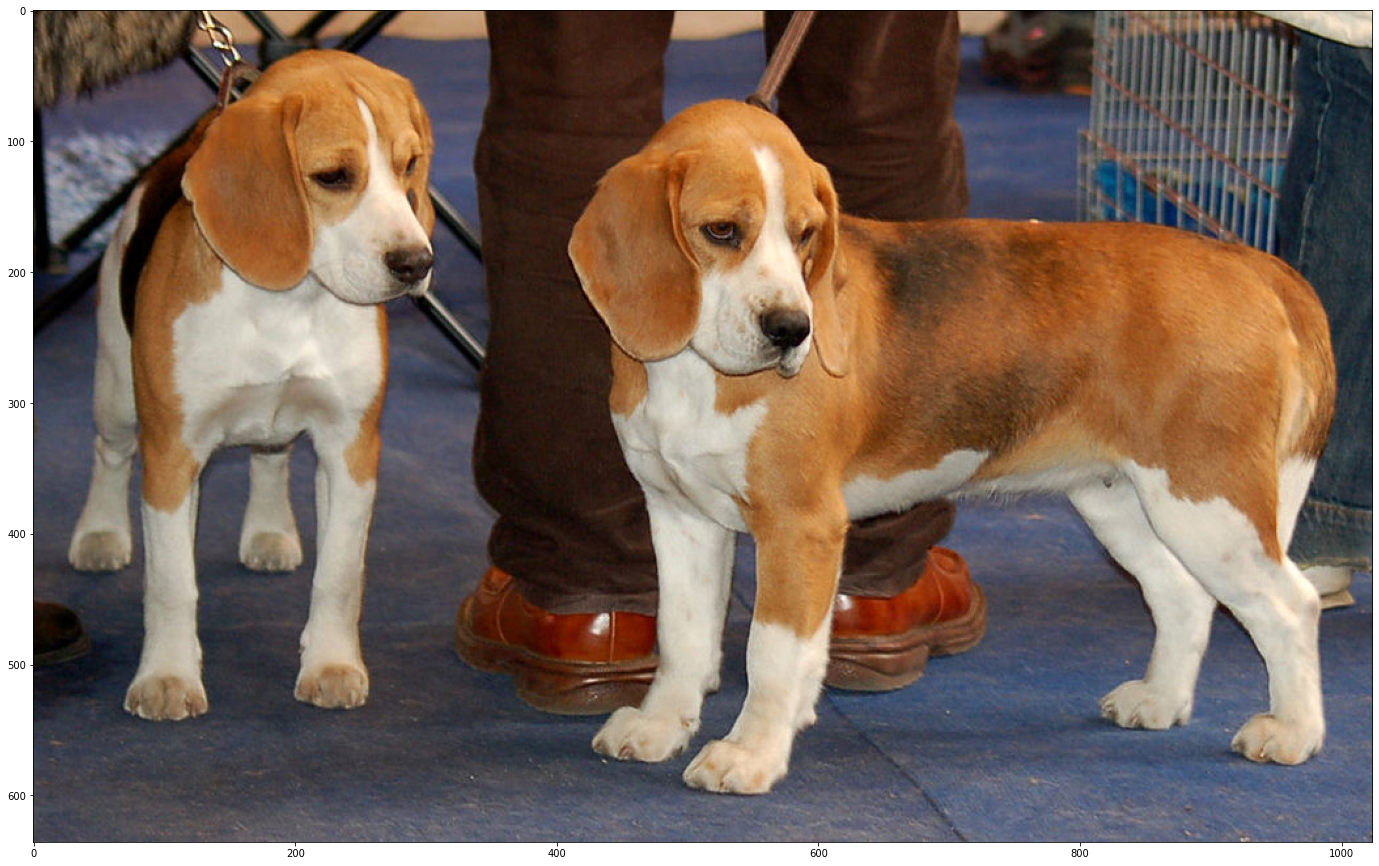

In [57]:
selected_image = 'Dogs' # @param ['Beach', 'Dogs', 'Naxos Taverna', 'Beatles', 'Phones', 'Birds']
flip_image_horizontally = False
convert_image_to_grayscale = False

image_path = IMAGES_FOR_TEST[selected_image]
print(image_path)
image_np = load_image_into_numpy_array(image_path)


## Image preprocessing
if flip_image_horizontally:
    image_np[0] = np.fliplr(image_np[0]).copy()
    
if convert_image_to_grayscale:
    image_np[0] = np.tile(np.mean(image_np[0], 2, keepdims=True), (1,1,3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [58]:
print('Doing the inference...')
results = hub_model(image_np)
print('Complete the inference.')

result = {key:value.numpy() for key, value in results.items()}
print(result.keys())

Doing the inference...
Complete the inference.
dict_keys(['num_detections', 'detection_keypoints', 'detection_keypoint_scores', 'detection_scores', 'detection_boxes', 'detection_classes'])


In [59]:
## Dig into result

print(result['detection_keypoint_scores'])
print([category_index[x] for x in result['detection_classes'][0]])

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.12409189 0.83089864 0.12857717]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.1        0.1        0.1        ... 0.1        0.1        0.1       ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
[{'id': 18, 'name': 'dog'}, {'id': 18, 'name': 'dog'}, {'id': 1, 'name': 'person'}, {'id': 1, 'name': 'person'}, {'id': 1, 'name': 'person'}, {'id': 1, 'name': 'person'}, {'id': 62, 'name': 'chair'}, {'id': 18, 'name': 'dog'}, {'id': 18, 'name': 'dog'}, {'id': 1, 'name': 'person'}, {'id': 62, 'name': 'chair'}, {'id': 37, 'name': 'sports ball'}, {'id': 15, 'name': 'bench'}, {'id': 1, 'name': 'person'}, {'id': 18, 'name': 'dog'}, {'id': 18, 'name': 'dog'}, {'id': 3, 'name': 'car'}, {'id': 64, 'name': 'potted plant'}, {'id': 51, 'name': 'bowl'},

# Visualizing the results

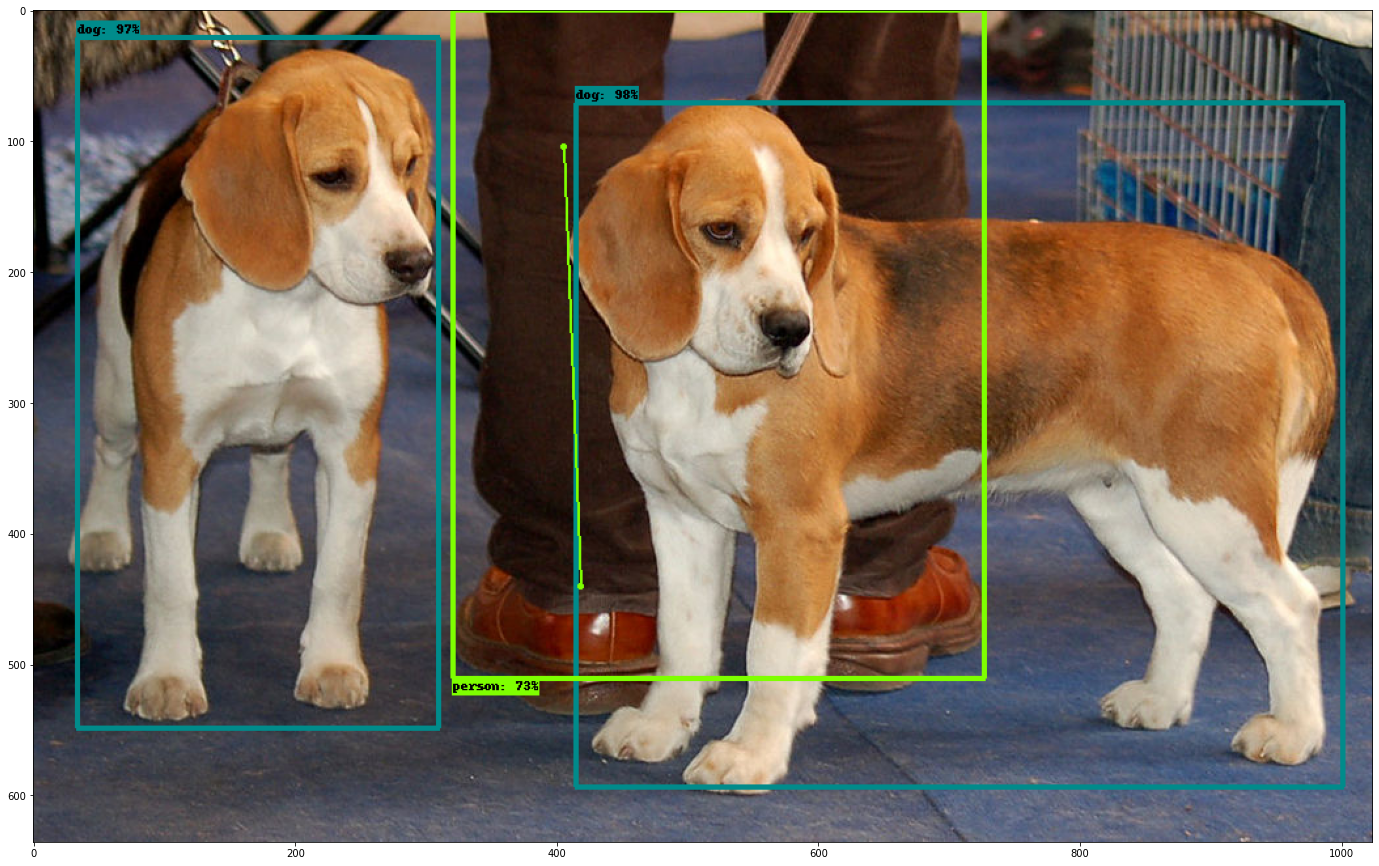

In [60]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

keypoints, keypoint_scores = None, None

if 'detection_keypoints' in result:
    keypoints = result['detection_keypoints'][0]
    keypoint_scores = result['detection_keypoint_scores'][0]


viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

# Option

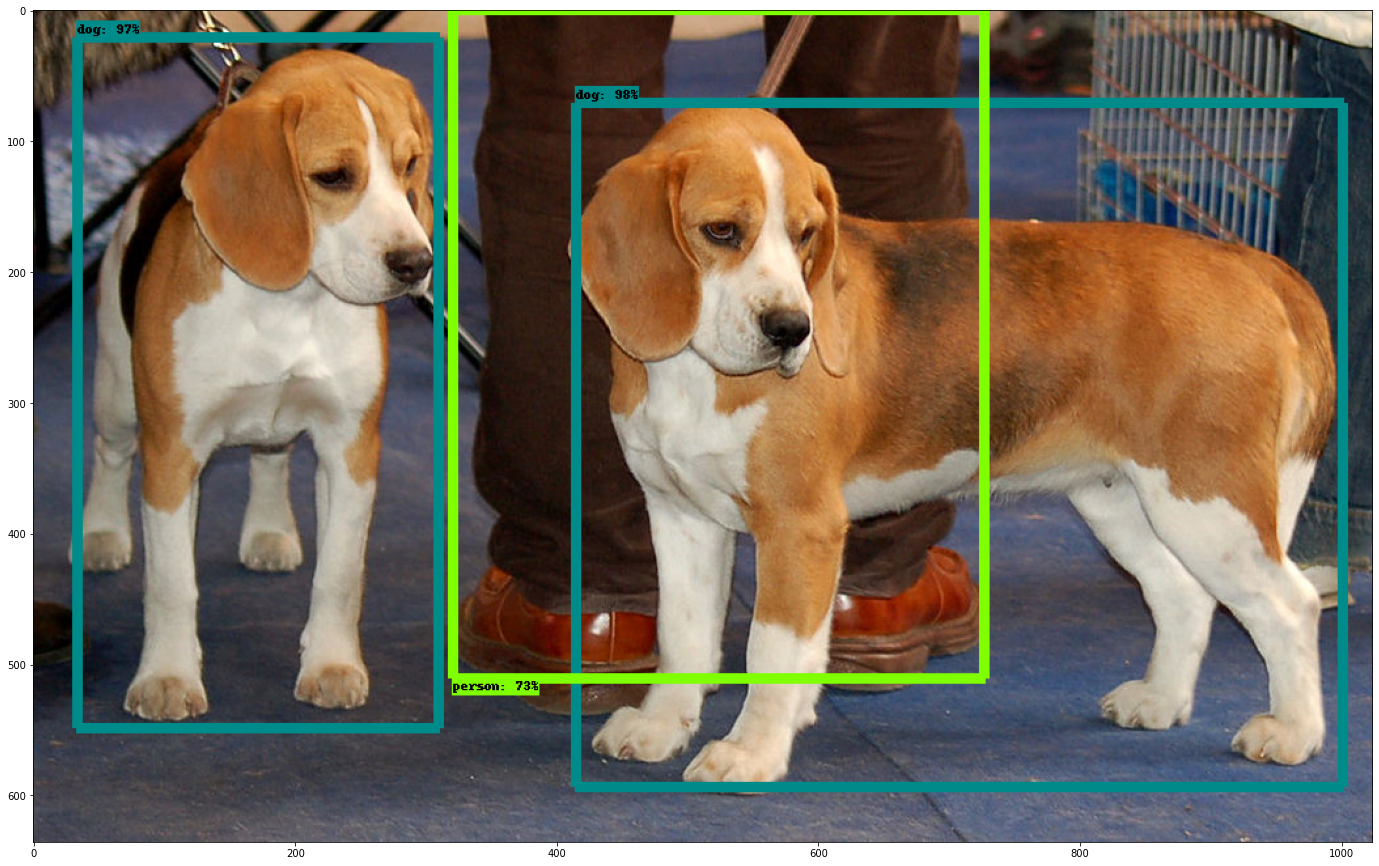

In [61]:
# Handle models with masks:
image_np_with_mask = image_np.copy()

if 'detection_masks' in result:
  # we need to convert np.arrays to tensors
  detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

  # Reframe the the bbox mask to the image size.
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_np.shape[1], image_np.shape[2])
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                      tf.uint8)
  result['detection_masks_reframed'] = detection_masks_reframed.numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_mask[0])
plt.show()